# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_3m_0f_240220_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [90, 1830]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 90000
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,350.914758,14.212040,350.962481,14.221283,0.0,300.000000,0.000000,0.576471,390.000000,1.000000,1.531151,1877.0,107.869773,30.696254,0.958656,6
1,1,0,870.533435,77.319656,870.430552,77.022747,NaN,870.533435,77.319656,NaN,870.533435,77.319656,1.216297,1974.0,109.191394,56.283550,0.856915,6
2,2,0,1392.992611,98.366597,1386.794948,102.140121,0.0,1436.000000,48.000000,0.396078,1369.000000,121.000000,-1.528370,13939.0,188.949636,98.355839,0.853837,6
3,3,0,740.529012,94.748856,740.620333,96.086198,NaN,740.529012,94.748856,NaN,740.529012,94.748856,-1.230544,6773.0,195.553024,65.796257,0.941697,6
4,4,0,1055.559921,154.116187,1060.675101,152.880249,0.0,1068.000000,112.000000,0.431373,1136.000000,140.000000,-1.463195,13134.0,217.091854,80.955354,0.927868,6
5,5,0,1360.760413,613.160651,1360.639234,613.024703,0.0,1330.000000,554.000000,0.513725,1348.000000,636.000000,0.283847,5042.0,112.422977,75.275761,0.742743,6


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([2, 3, 4])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        -tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x  position_y  orientation
0   0     0         6   350.914758   14.212040     1.531151
1   1     0         6   870.533435   77.319656     1.216297
2   2     0         6  1392.992611   98.366597    -1.528370
3   3     0         6   740.529012   94.748856    -1.230544
4   4     0         6  1055.559921  154.116187    -1.463195
5   5     0         6  1360.760413  613.160651     0.283847


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
2,0,0,1392.992611,98.366597,1386.794948,102.140121,0.0,1436.000000,48.000000,0.396078,1369.000000,121.000000,-1.528370,13939.0,188.949636,98.355839,0.853837,6
3,1,0,740.529012,94.748856,740.620333,96.086198,NaN,740.529012,94.748856,NaN,740.529012,94.748856,1.230544,6773.0,195.553024,65.796257,0.941697,6
4,2,0,1055.559921,154.116187,1060.675101,152.880249,0.0,1068.000000,112.000000,0.431373,1136.000000,140.000000,1.463195,13134.0,217.091854,80.955354,0.927868,6
6,0,3,350.961032,13.764613,350.998222,13.767927,0.0,300.000000,0.000000,0.576471,387.000000,1.000000,1.534420,1899.0,108.442571,29.758613,0.961610,6
7,1,3,773.102195,89.784130,779.240422,89.721274,NaN,773.102195,89.784130,NaN,773.102195,89.784130,-1.381932,8973.0,280.045362,73.804146,0.964648,6
8,2,3,1392.928541,98.323353,1386.825315,102.096472,0.0,1435.000000,48.000000,0.396078,1411.000000,116.000000,-1.532784,13994.0,189.281796,98.528312,0.853839,6
9,3,3,812.085463,116.233227,810.857970,116.201034,NaN,812.085463,116.233227,NaN,812.085463,116.233227,-1.536032,1252.0,97.815125,25.620356,0.965088,6


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
60111,1,89997,359.127730,21.817928,359.231827,21.803225,0.0,394.000000,1.00000,0.584314,394.000000,0.00000,1.475663,3938.0,117.679402,55.244174,0.882961,6
60112,2,89997,1556.785561,143.866315,1555.530747,141.031786,0.0,1616.000000,48.00000,0.317647,1531.000000,139.00000,-0.731850,14018.0,211.411260,87.984879,0.909283,6
60113,3,89997,1624.508157,386.231090,1622.139618,384.724669,NaN,1624.508157,386.23109,NaN,1624.508157,386.23109,0.138338,10788.0,222.223101,84.716138,0.924484,6
60114,4,89997,1623.179108,742.574202,1620.788214,752.685261,0.0,1620.000000,634.00000,0.501961,1608.000000,653.00000,0.002119,12311.0,246.537943,72.648031,0.955598,6
60115,5,89997,1451.955988,1065.648925,1451.120530,1065.660793,0.0,1522.000000,1038.00000,0.407843,1419.000000,1076.00000,-1.550693,1954.0,187.670366,30.344937,0.986841,6


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


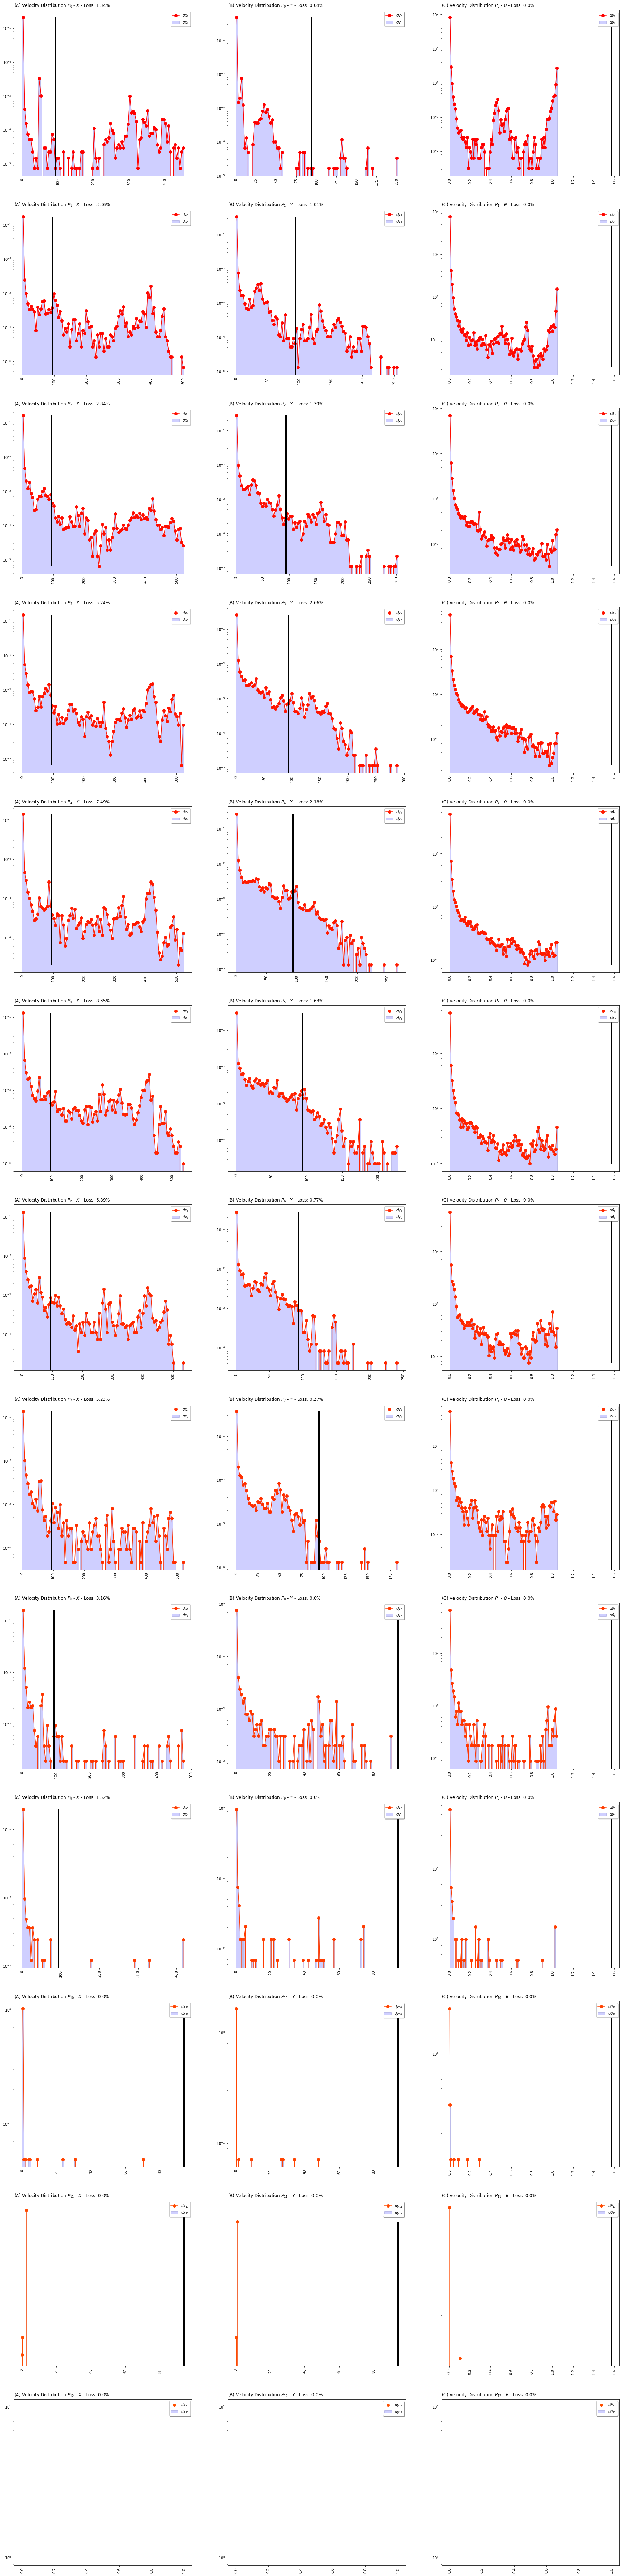

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,3,303
1,4,7752
2,5,42620
3,6,55479
4,7,42686
5,8,23872
6,9,8190
7,10,1680
8,11,286
9,12,36


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 48.916286832903666 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.142688
1,3,False,True,False,0.005467
2,3,True,False,False,0.010387
3,3,True,True,False,0.007107
4,4,False,False,False,4.028603
5,4,False,True,False,0.069430
6,4,True,False,False,0.106059
7,4,True,True,False,0.033895
8,5,False,False,False,22.401964
9,5,False,True,False,0.238906


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 4.548276494596994 
	- Angle: 48.916286832903666 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 45.20544459992367%
Final loss data X-axis: 10.165797396429632%
Final loss data Y-axis: 10.247211974727557%
Final loss data Angle : 2.1744476953737863%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.010177
1,3,False,False,True,0.287495
2,3,False,True,False,0.009329
3,3,False,True,True,0.283255
4,3,True,False,False,0.002544
...,...,...,...,...,...
65,11,False,False,True,0.055973
66,11,False,True,False,0.002544
67,11,False,True,True,0.000848
68,11,True,False,True,0.006785


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 4.548276494596994 
	- Angle: 48.916286832903666 



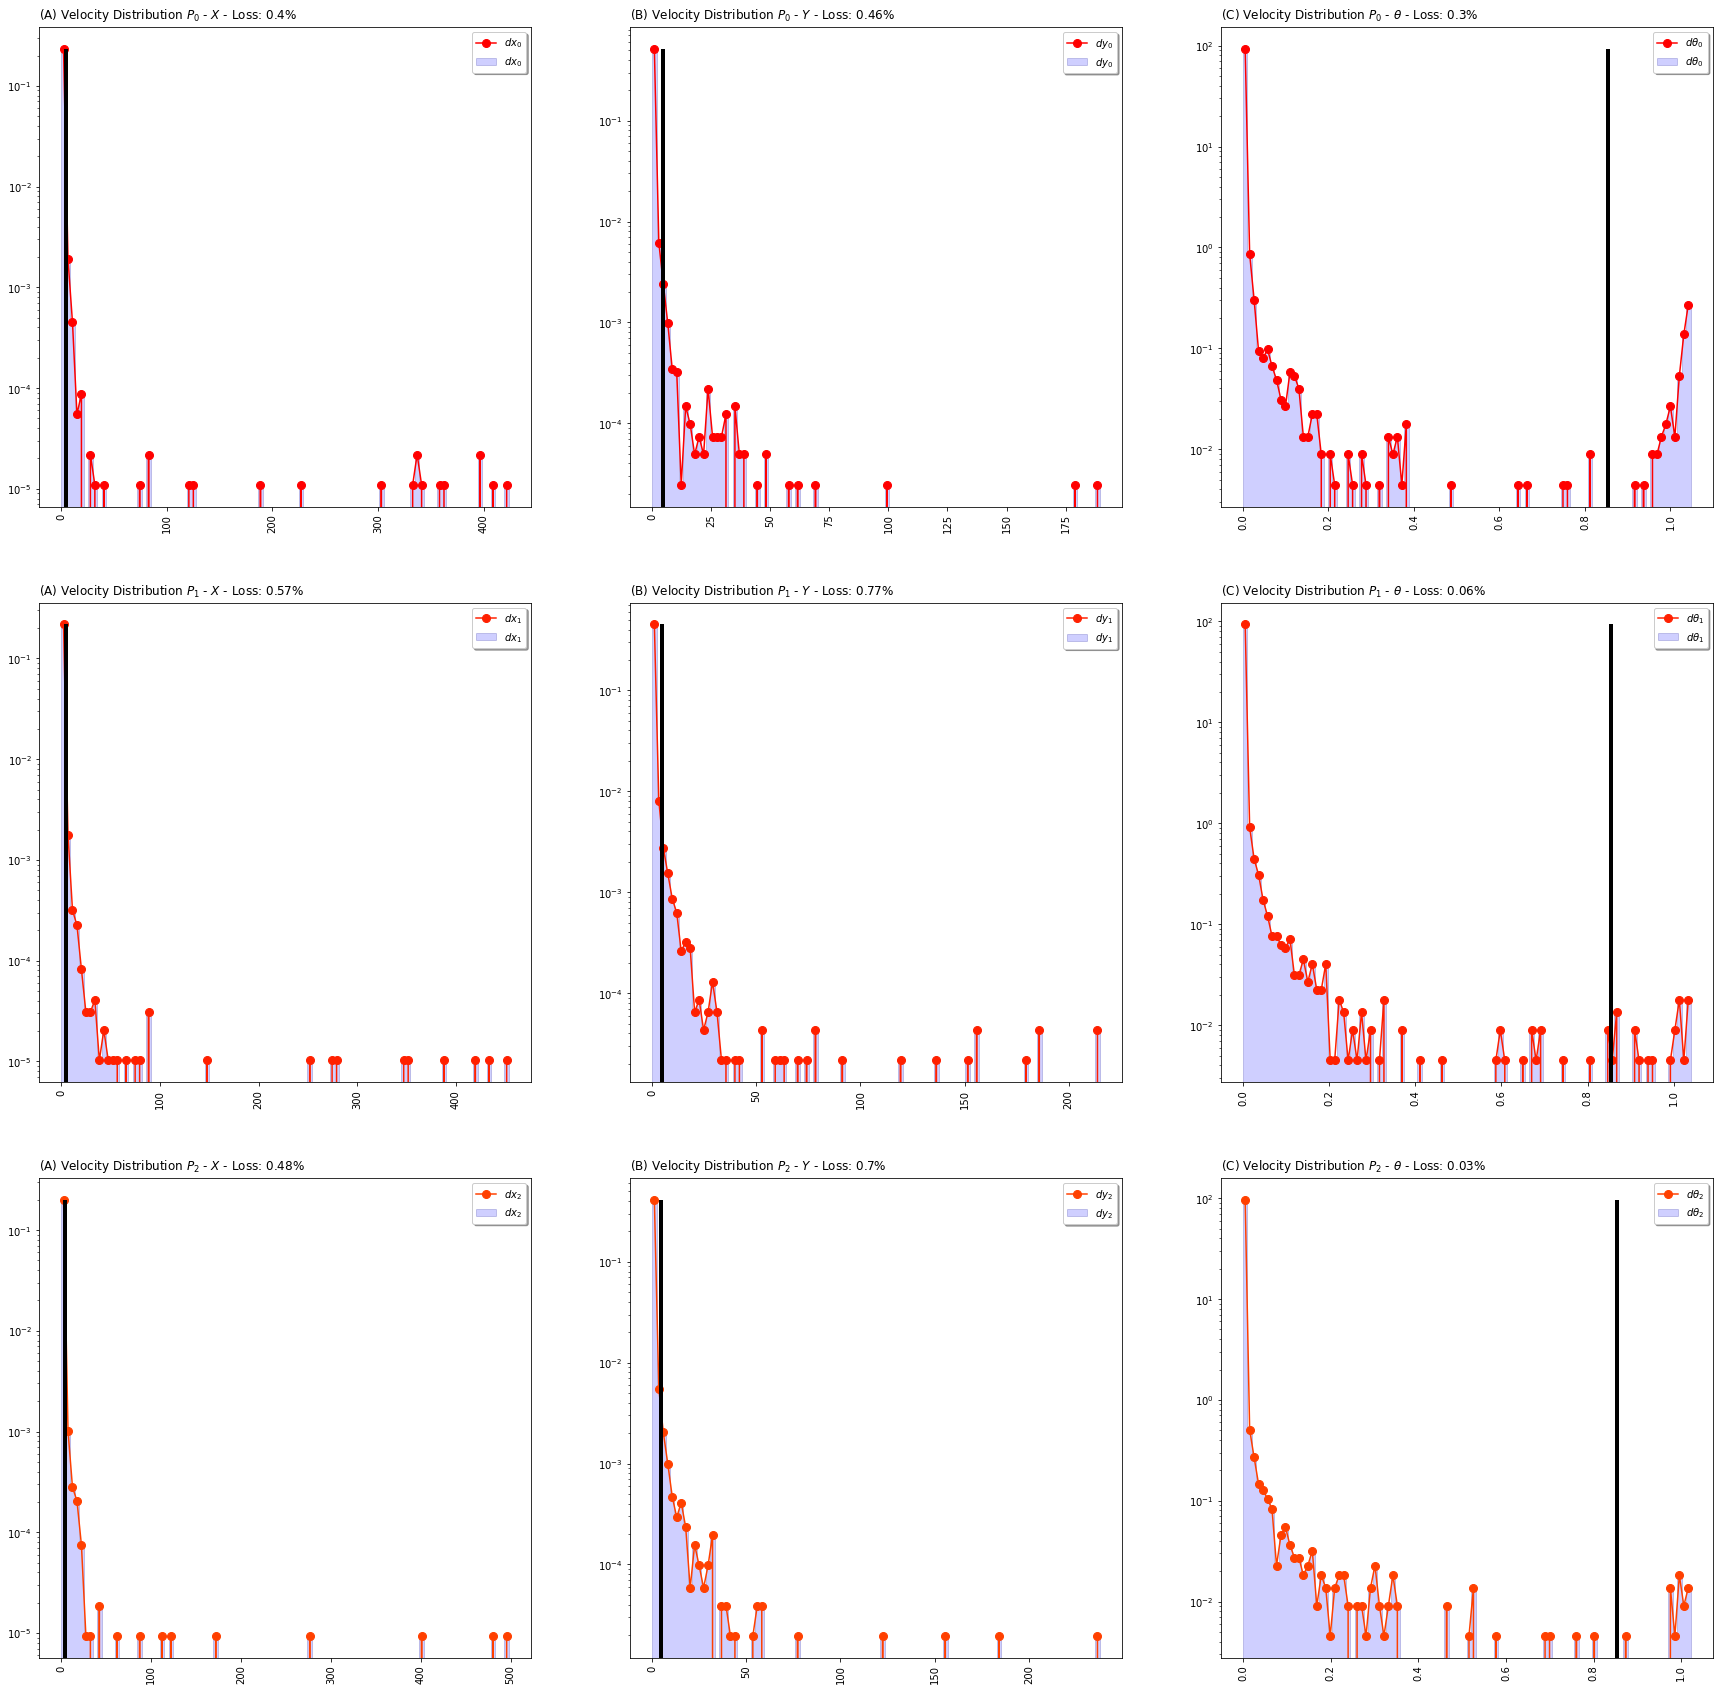

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1392.992611,98.366597,1386.794948,102.140121,0.0,1436.000000,48.000000,0.396078,1369.000000,121.000000,-1.528370,13939.0,188.949636,98.355839,0.853837,3,NaN,NaN,NaN,NaN,False,False,False
102,1,0,740.529012,94.748856,740.620333,96.086198,NaN,740.529012,94.748856,NaN,740.529012,94.748856,1.230544,6773.0,195.553024,65.796257,0.941697,3,NaN,NaN,NaN,NaN,False,False,False
204,2,0,1055.559921,154.116187,1060.675101,152.880249,0.0,1068.000000,112.000000,0.431373,1136.000000,140.000000,1.463195,13134.0,217.091854,80.955354,0.927868,3,NaN,NaN,NaN,NaN,False,False,False
307,0,3,1392.928541,98.323353,1386.825315,102.096472,0.0,1435.000000,48.000000,0.396078,1411.000000,116.000000,-1.532784,13994.0,189.281796,98.528312,0.853839,3,3.0,-0.021357,-0.014415,-0.001471,False,False,False
306,1,3,792.593829,103.008679,795.049196,102.961154,NaN,792.593829,103.008679,NaN,792.593829,103.008679,-1.381932,8973.0,280.045362,73.804146,0.964648,3,3.0,17.354939,2.753274,-0.870825,True,False,False
308,2,3,1058.815217,154.591108,1064.063856,153.496502,0.0,1119.000000,112.000000,0.427451,1057.000000,179.000000,-1.469258,13248.0,218.187560,81.353198,0.927888,3,3.0,1.085099,0.158307,-0.977484,False,False,False
310,0,6,1392.928541,98.323353,1386.825315,102.096472,0.0,1435.000000,48.000000,0.396078,1411.000000,116.000000,-1.532784,13994.0,189.281796,98.528312,0.853839,3,3.0,0.000000,0.000000,0.000000,False,False,False
309,1,6,792.593829,103.008679,795.049196,102.961154,NaN,792.593829,103.008679,NaN,792.593829,103.008679,-1.381932,8973.0,280.045362,73.804146,0.964648,3,3.0,0.000000,0.000000,0.000000,False,False,False
311,2,6,1060.497871,154.732969,1065.797788,153.656075,0.0,1094.500000,113.000000,0.427451,1087.000000,154.500000,-1.469258,13248.0,218.187560,81.353198,0.927888,3,3.0,0.560884,0.047287,0.000000,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_3m_0f_240220_1_c.zip'